### Classifying Urban sounds using Deep Learning

#### Dependencies

In [ ]:
# Only run these if you selected SageMaker approach
!pip3 install --upgrade pip
!pip3 install -r requirements.txt
!conda install -n tensorflow_p36 -c conda-forge -y librosa

#### Visualizing Audio

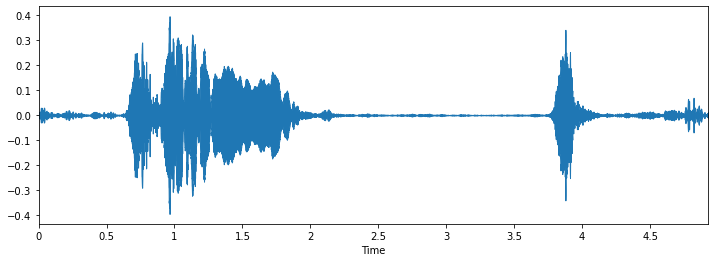

In [1]:
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

filename = './model/bark.wav'
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

#### Download & Unzip Dataset

In [2]:
# You will need to download this dataset yourself. Unfortunately this guide uses the
# 2014 dataset (and not the updated one). Google and look for the dataset that is ~6GB.
!aws s3 cp s3://devopstar/resources/dog-bark-detection/UrbanSound8K.tar.gz ./model/UrbanSound8K.tar.gz
!tar -xf ./model/UrbanSound8K.tar.gz -C ./model/

zsh:1: command not found: aws
tar: Error opening archive: Failed to open './model/UrbanSound8K.tar.gz'


#### Load Dataset

In [6]:
import librosa
import numpy as np

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [4]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
fulldatasetpath = './model/UrbanSound8K/audio/'
metadata = pd.read_csv('./model/UrbanSound8K/metadata/UrbanSound8K.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(
        os.path.abspath(fulldatasetpath),
        'fold' + str(row["fold"]) + '/',
        str(row["slice_file_name"])
    )
    
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class'])

print('Finished feature extraction from ', len(featuresdf), ' files')

/Users/cheffbcookin/miniconda3/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
/Users/cheffbcookin/miniconda3/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
/Users/cheffbcookin/miniconda3/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(


Finished feature extraction from  8732  files


In [7]:
print(featuresdf)

                                                feature             class
0     [-215.79301, 71.66612, -131.81377, -52.091328,...          dog_bark
1     [-424.68677, 110.56227, -54.148235, 62.01073, ...  children_playing
2     [-459.56467, 122.800354, -47.92471, 53.265694,...  children_playing
3     [-414.55377, 102.896904, -36.66495, 54.180405,...  children_playing
4     [-447.397, 115.0954, -53.809113, 61.608585, 1....  children_playing
...                                                 ...               ...
8727  [-399.2257, 136.81903, -51.964222, 37.023987, ...          car_horn
8728  [-346.72733, 87.48847, -46.265022, 52.748833, ...          car_horn
8729  [-304.61316, 112.6199, -47.161945, 37.00349, -...          car_horn
8730  [-344.71423, 126.75814, -56.17717, 36.070927, ...          car_horn
8731  [-315.93384, 95.67589, -38.047768, 47.500736, ...          car_horn

[8732 rows x 2 columns]


In [8]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


#### Convert the data and labels

In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
class_list = featuresdf['class']
y = np.array(class_list.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

#### Split the dataset

In [11]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

### Training and Evaluation

In [12]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

2021-12-07 01:02:39.715437: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Compile the model

In [13]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [14]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               10496     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

#### Training

In [15]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='model/weights.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
194/219 [=========================>....] - ETA: 0s - loss: 9.7726 - accuracy: 0.1854 
Epoch 00001: val_loss improved from inf to 2.14666, saving model to model/weights.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 8.9672 - accuracy: 0.1878 - val_loss: 2.1467 - val_accuracy: 0.2347
Epoch 2/100
191/219 [=========================>....] - ETA: 0s - loss: 2.2439 - accuracy: 0.2407
Epoch 00002: val_loss improved from 2.14666 to 2.05564, saving model to model/weights.hdf5
219/219 [==============================] - 1s 3ms/step - loss: 2.2307 - accuracy: 0.2437 - val_loss: 2.0556 - val_accuracy: 0.2730
Epoch 3/100
215/219 [============================>.] - ETA: 0s - loss: 2.0363 - accuracy: 0.2908
Epoch 00003: val_loss improved from 2.05564 to 1.81095, saving model to model/weights.hdf5
219/219 [==============================] - 1s 3ms/step - loss: 2.0338 - accuracy: 0.2916 - val_loss: 1.8110 - val_accuracy: 0.3709
Epoch 4/100
198/219 [=========================

Epoch 27/100
203/219 [==========================>...] - ETA: 0s - loss: 0.8101 - accuracy: 0.7248
Epoch 00027: val_loss improved from 0.63322 to 0.59751, saving model to model/weights.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 0.8090 - accuracy: 0.7254 - val_loss: 0.5975 - val_accuracy: 0.8185
Epoch 28/100
197/219 [=========================>....] - ETA: 0s - loss: 0.7994 - accuracy: 0.7222
Epoch 00028: val_loss improved from 0.59751 to 0.58481, saving model to model/weights.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 0.8035 - accuracy: 0.7234 - val_loss: 0.5848 - val_accuracy: 0.8237
Epoch 29/100
198/219 [==========================>...] - ETA: 0s - loss: 0.7861 - accuracy: 0.7312
Epoch 00029: val_loss did not improve from 0.58481
219/219 [==============================] - 0s 2ms/step - loss: 0.7947 - accuracy: 0.7296 - val_loss: 0.5944 - val_accuracy: 0.8168
Epoch 30/100
202/219 [==========================>...] - ETA: 0s - loss: 0.7952 -

Epoch 55/100
197/219 [=========================>....] - ETA: 0s - loss: 0.6166 - accuracy: 0.7927
Epoch 00055: val_loss did not improve from 0.47563
219/219 [==============================] - 0s 2ms/step - loss: 0.6111 - accuracy: 0.7948 - val_loss: 0.4821 - val_accuracy: 0.8523
Epoch 56/100
206/219 [===========================>..] - ETA: 0s - loss: 0.6042 - accuracy: 0.7928
Epoch 00056: val_loss did not improve from 0.47563
219/219 [==============================] - 0s 2ms/step - loss: 0.6081 - accuracy: 0.7910 - val_loss: 0.4906 - val_accuracy: 0.8472
Epoch 57/100
212/219 [============================>.] - ETA: 0s - loss: 0.6015 - accuracy: 0.7975
Epoch 00057: val_loss did not improve from 0.47563
219/219 [==============================] - 0s 2ms/step - loss: 0.5968 - accuracy: 0.7990 - val_loss: 0.4859 - val_accuracy: 0.8512
Epoch 58/100
213/219 [============================>.] - ETA: 0s - loss: 0.6231 - accuracy: 0.7905
Epoch 00058: val_loss did not improve from 0.47563
219/219 [==

Epoch 84/100
207/219 [===========================>..] - ETA: 0s - loss: 0.5442 - accuracy: 0.8199
Epoch 00084: val_loss did not improve from 0.43360
219/219 [==============================] - 0s 2ms/step - loss: 0.5431 - accuracy: 0.8189 - val_loss: 0.4609 - val_accuracy: 0.8735
Epoch 85/100
195/219 [=========================>....] - ETA: 0s - loss: 0.5283 - accuracy: 0.8186
Epoch 00085: val_loss did not improve from 0.43360
219/219 [==============================] - 0s 2ms/step - loss: 0.5247 - accuracy: 0.8188 - val_loss: 0.4549 - val_accuracy: 0.8758
Epoch 86/100
208/219 [===========================>..] - ETA: 0s - loss: 0.5494 - accuracy: 0.8145
Epoch 00086: val_loss did not improve from 0.43360
219/219 [==============================] - 0s 2ms/step - loss: 0.5452 - accuracy: 0.8152 - val_loss: 0.4491 - val_accuracy: 0.8718
Epoch 87/100
213/219 [============================>.] - ETA: 0s - loss: 0.5342 - accuracy: 0.8192
Epoch 00087: val_loss did not improve from 0.43360
219/219 [==

#### Test the model

In [16]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9289907217025757
Testing Accuracy:  0.8654837012290955


#### Predictions

In [17]:
import librosa
import numpy as np

def extract_feature(file_name):
   
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

    return np.array([mfccsscaled])

def print_prediction(file_name):
    prediction_feature = extract_feature(file_name)

    predicted_vector = model.predict(prediction_feature)
    predicted_vector = np.argmax(predicted_vector, axis = 1)
    predicted_class = le.inverse_transform(predicted_vector)
    print("The predicted class is:", predicted_class[0], '\n')

    '''
    predicted_proba_vector = model.predict_proba(prediction_feature)
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)):
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f'))
    
    
    '''

#### Validation

In [14]:
# Class: Dog Bark

filename = './model/7061-6-0-0.wav'

print_prediction(filename)

filename = './model/mixkit-annoyed-big-dog-barking-51.wav'

print_prediction(filename)

filename = './model/labrador-barking-daniel_simon.wav'
print_prediction(filename)


filename = './model/bark3.wav'
print_prediction(filename)


#https://console.firebase.google.com/u/0/project/woof-91636/firestore/data/~2F



The predicted class is: gun_shot 

The predicted class is: dog_bark 

The predicted class is: dog_bark 

The predicted class is: dog_bark 



In [15]:
model_file_name = "local-dog-bark-detection-model"

import joblib

In [16]:
joblib.dump(model, model_file_name)

2021-11-24 02:35:18.675462: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://7262ad2c-5d9a-4ae1-b8ab-d31b274c6007/assets


['local-dog-bark-detection-model']

In [17]:
model2 = joblib.load(model_file_name)

In [18]:
def print_prediction2(file_name):
    prediction_feature = extract_feature(file_name)

    predicted_vector = model2.predict(prediction_feature)
    predicted_vector = np.argmax(predicted_vector, axis = 1)
    predicted_class = le.inverse_transform(predicted_vector)
    print("The predicted class is:", predicted_class[0], '\n')

In [19]:
filename = './model/7061-6-0-0.wav'

print_prediction2(filename)

filename = './model/mixkit-annoyed-big-dog-barking-51.wav'

print_prediction2(filename)

The predicted class is: gun_shot 

The predicted class is: dog_bark 



In [21]:
model.save('model/meta')

INFO:tensorflow:Assets written to: model/meta/assets
